# Exercises - Estimating the Spot Curve

#### Notation Commands

$$\newcommand{\Black}{\mathcal{B}}
\newcommand{\Blackcall}{\Black_{\mathrm{call}}}
\newcommand{\Blackput}{\Black_{\mathrm{put}}}
\newcommand{\EcondS}{\hat{S}_{\mathrm{conditional}}}
\newcommand{\Efwd}{\mathbb{E}^{T}}
\newcommand{\Ern}{\mathbb{E}^{\mathbb{Q}}}
\newcommand{\Tfwd}{T_{\mathrm{fwd}}}
\newcommand{\Tunder}{T_{\mathrm{bond}}}
\newcommand{\accint}{A}
\newcommand{\carry}{\widetilde{\cpn}}
\newcommand{\cashflow}{C}
\newcommand{\convert}{\phi}
\newcommand{\cpn}{c}
\newcommand{\ctd}{\mathrm{CTD}}
\newcommand{\disc}{Z}
\newcommand{\done}{d_{1}}
\newcommand{\dt}{\Delta t}
\newcommand{\dtwo}{d_{2}}
\newcommand{\flatvol}{\sigma_{\mathrm{flat}}}
\newcommand{\flatvolT}{\sigma_{\mathrm{flat},T}}
\newcommand{\float}{\mathrm{flt}}
\newcommand{\freq}{m}
\newcommand{\futprice}{\mathcal{F}(t,T)}
\newcommand{\futpriceDT}{\mathcal{F}(t+h,T)}
\newcommand{\futpriceT}{\mathcal{F}(T,T)}
\newcommand{\futrate}{\mathscr{f}}
\newcommand{\fwdprice}{F(t,T)}
\newcommand{\fwdpriceDT}{F(t+h,T)}
\newcommand{\fwdpriceT}{F(T,T)}
\newcommand{\fwdrate}{f}
\newcommand{\fwdvol}{\sigma_{\mathrm{fwd}}}
\newcommand{\fwdvolTi}{\sigma_{\mathrm{fwd},T_i}}
\newcommand{\grossbasis}{B}
\newcommand{\hedge}{\Delta}
\newcommand{\ivol}{\sigma_{\mathrm{imp}}}
\newcommand{\logprice}{p}
\newcommand{\logyield}{y}
\newcommand{\mat}{(n)}
\newcommand{\nargcond}{d_{1}}
\newcommand{\nargexer}{d_{2}}
\newcommand{\netbasis}{\tilde{\grossbasis}}
\newcommand{\normcdf}{\mathcal{N}}
\newcommand{\notional}{K}
\newcommand{\pfwd}{P_{\mathrm{fwd}}}
\newcommand{\pnl}{\Pi}
\newcommand{\price}{P}
\newcommand{\probexer}{\hat{\mathcal{P}}_{\mathrm{exercise}}}
\newcommand{\pvstrike}{K^*}
\newcommand{\refrate}{r^{\mathrm{ref}}}
\newcommand{\rrepo}{r^{\mathrm{repo}}}
\newcommand{\spotrate}{r}
\newcommand{\spread}{s}
\newcommand{\strike}{K}
\newcommand{\swap}{\mathrm{sw}}
\newcommand{\swaprate}{\cpn_{\swap}}
\newcommand{\tbond}{\mathrm{fix}}
\newcommand{\ttm}{\lam}
\newcommand{\value}{V}
\newcommand{\vega}{\nu}
\newcommand{\years}{\lam}
\newcommand{\yearsACT}{\lam_{\mathrm{act/360}}}
\newcommand{\yield}{Y}$$

### Data

This exercise uses the data file, `treasury_quotes_2025-11-28`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `type` `TIPS Note` or `TIPS bond`.

In [374]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 1. Discount Rates

Use the data in the `selected quotes` tab.

Note:
* The selected treasuries are at nearly six-month intervals. 
* If you prefer, approximate that they mature at perfect 6-month intervals. 

In [375]:
data = pd.read_excel("treasury_quotes_2025-11-28.xlsx", sheet_name="selected quotes",
                     parse_dates=["quote date", "issue date", "maturity date"])
data.head()

,KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm,total size,duration
0,208227,note,2025-11-28,2024-05-31,2026-05-31,0.503765,0.989071,4.875,100.521406,100.531220,100.526313,2.410861,102.937174,0.038263,7.142500e+10,0.492305
1,208316,note,2025-11-28,2024-11-30,2026-11-30,1.004791,0.989071,4.250,100.572266,100.591764,100.582015,2.101776,102.683791,0.036575,7.314900e+10,0.974601
2,208399,note,2025-11-28,2025-05-31,2027-05-31,1.503080,0.989071,3.875,100.453125,100.472656,100.462891,1.916325,102.379216,0.035621,7.844000e+10,1.448055
3,208484,note,2025-11-28,2025-11-30,2027-11-30,2.004107,0.000000,3.375,99.765625,99.769531,99.767578,0.000000,99.767578,0.034889,NaN,1.956136
4,208058,note,2025-11-28,2023-05-31,2028-05-31,2.505133,0.989071,3.625,100.312500,100.332031,100.322266,1.792691,102.114957,0.034901,4.936300e+10,2.376588


In [376]:
data.type.unique()

array(['note'], dtype=object)

### 1.1.

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

In [385]:
from pandas.tseries.offsets import MonthEnd

def treasury_cashflow_dates(issue, maturity):
    dates = (pd.date_range(
        start=issue,
        end=maturity,
        freq="6MS"   # semiannual
    ) - pd.Timedelta(days=1))

    if (maturity + MonthEnd(0)) not in dates:
        dates = dates.append(pd.DatetimeIndex([maturity + MonthEnd(0)]))

    return dates

all_dates = pd.to_datetime(sorted(
    set(
        date
        for _, row in data.iterrows()
        for date in treasury_cashflow_dates(row['issue date'], row['maturity date'])
    )
))

C = pd.DataFrame(
    0.0,
    index=data.index,
    columns=all_dates
)

FACE = 100

for i, row in data.iterrows():
    coupon_payment = FACE * row['cpn rate']/100 / 2
    payment_dates = treasury_cashflow_dates(row["issue date"], row["maturity date"])

    for d in payment_dates:
        C.loc[i, d] += coupon_payment

    C.loc[i, row["maturity date"] + MonthEnd(0)] += FACE

C = C.loc[:, (C > FACE).any()]

C


,2026-05-31,2026-11-30,2027-05-31,2027-11-30,2028-05-31,2028-11-30,2029-05-31,2029-11-30,2030-05-31,2030-11-30,2031-05-31,2031-11-30,2032-05-31,2032-11-30,2033-05-31,2033-11-30,2034-05-31,2034-11-30,2035-05-31,2035-11-30
0,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
1,2.1250,102.1250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
2,1.9375,1.9375,101.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
3,1.6875,1.6875,1.6875,101.6875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
4,1.8125,1.8125,1.8125,1.8125,101.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
5,2.1875,2.1875,2.1875,2.1875,2.1875,102.1875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
6,2.2500,2.2500,2.2500,2.2500,2.2500,2.2500,102.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
7,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
8,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,102.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0
9,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,101.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0


### 1.2.

Estimate the spot discount factors that rationalize the market prices of the treasuries. Do this via solving the linear system

$$\textbf{p} = {\textbf{C}}\, \textbf{z}$$

In [401]:
p = data["price"].astype(float).to_numpy()
z_hat, _, _, _ = np.linalg.lstsq(C.to_numpy(), p, rcond=None)
z = pd.Series(z_hat, index=data["ttm"], name="discount_factor")
z

ttm
0.503765    0.981343
1.004791    0.964472
1.503080    0.948551
2.004107    0.933088
2.505133    0.917225
3.006160    0.901050
3.504449    0.884954
4.005476    0.868448
4.503765    0.852545
5.004791    0.836465
5.503080    0.818640
6.004107    0.801868
6.505133    0.784631
7.006160    0.767992
7.460643    0.750850
7.964408    0.735044
8.459959    0.718142
8.963723    0.700921
9.459274    0.684347
9.963039    0.668448
Name: discount_factor, dtype: float64

### 1.3.

Plot the time-to-maturity on the horizontal axis. On the vertical axis, plot the...
* discount factors

Make another plot, this time with the vertical axis displaying the
* semiannually compounded discount rates
* continuously compounded discount rates

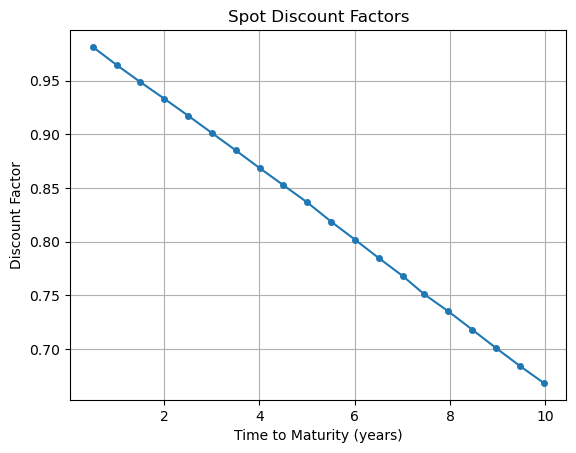

In [402]:
plt.plot(z.index, z, marker="o", markersize=4)
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Discount Factor")
plt.title("Spot Discount Factors")
plt.grid(True)
plt.show()


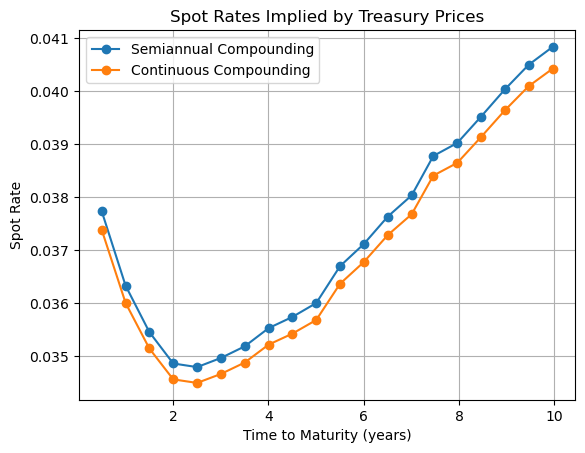

In [403]:
# Semiannually compounded
r_sa = 2 * (z.values ** (-1 / (2 * data["ttm"])) - 1)

# Continuously compounded
r_cc = -np.log(z.values) / data["ttm"]

plt.plot(data["ttm"], r_sa, marker="o", label="Semiannual Compounding")
plt.plot(data["ttm"], r_cc, marker="o", label="Continuous Compounding")
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Spot Rate")
plt.title("Spot Rates Implied by Treasury Prices")
plt.legend()
plt.grid(True)
plt.show()


### 1.4. Curve-Fitting

Estimate the discount curve via the Nelson-Siegel model.
* Fit via minimizing the sum of squared errors of the modeled prices against the quoted prices.
* Consider using `minimize` from `scipy.optimize`.

When done,
* Report the estimated NS parameters.
* Plot the semiannually-compounded discount rates along with those estimated with OLS from above.

In [404]:
from scipy.optimize import minimize

def r_ns(t, theta0, theta1, theta2, lam):
    x = t / lam
    return (
        theta0
        + theta1 * (1 - np.exp(-x)) / x
        + theta2 * ((1 - np.exp(-x)) / x - np.exp(-x))
    )

def loss(theta, t, C, p_mkt):
    theta0, theta1, theta2, lam = theta
    r = r_ns(t, theta0, theta1, theta2, lam)
    z = np.exp(-r * t)
    p_model = C.to_numpy() @ z
    return np.sum((p_model - p_mkt)**2)

x0 = np.array([0, 0, 0, 2])
p_mkt = data["price"]

res = minimize(
    loss,
    x0=x0,
    args=(data["ttm"], C, data["dirty price"]),
    method="L-BFGS-B",
    bounds=[(None, None), (None, None), (None, None), (1e-3, None)],
)

theta_hat = res.x

print("theta0: ", theta_hat[0])
print("theta1: ", theta_hat[1])
print("theta2: ", theta_hat[2])
print("lambda: ", theta_hat[3])

theta0:  0.05906609136521358
theta1:  -0.04137427484122139
theta2:  -0.0002661775382846684
lambda:  4.928505497693436


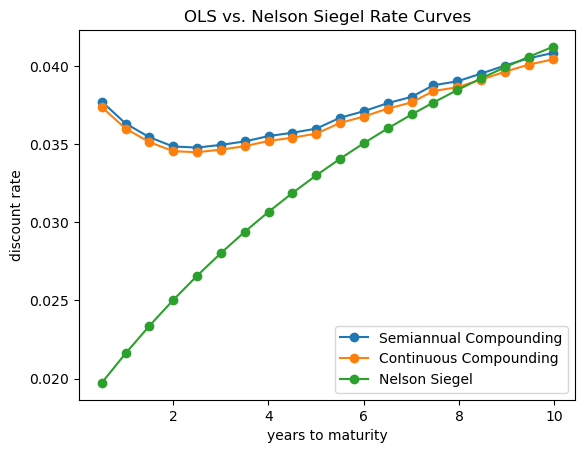

In [405]:
r_model = r_ns(data["ttm"], theta_hat[0], theta_hat[1], theta_hat[2], theta_hat[3])
plt.title("OLS vs. Nelson Siegel Rate Curves")
plt.xlabel("years to maturity")
plt.ylabel("discount rate")
plt.plot(data["ttm"], r_sa, marker="o", label="Semiannual Compounding")
plt.plot(data["ttm"], r_cc, marker="o", label="Continuous Compounding")
plt.plot(data["ttm"], r_model, marker="o", label="Nelson Siegel")
plt.legend()
plt.show()

***

# 2. Estimating the Discount Curve with Non-Evenly Spaced Data

Use the data in the `quotes` tab.

In [406]:
data = pd.read_excel("treasury_quotes_2025-11-28.xlsx", sheet_name="quotes", index_col="KYTREASNO",
                     parse_dates=["quote date", "issue date", "maturity date"])
data.shape

(455, 15)

### 2.1. Map Cashflows

Construct the cashflow matrix.

Given the unfiltered data set, you will need to make a few modeling choices to do this...
* eliminate any treasury that does not report YTM or that reports a negative YTM.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [407]:
data = data.loc[((data.type != "TIPS bond") & (data.type != "TIPS note"))]
data = data.loc[((data.ytm.notna()) & (data.ytm > 0))]
data.shape

(402, 15)

In [408]:
def generate_coupon_dates(row):
    dates = []
    d = row["maturity date"]

    while True:
        dates.append(d)
        d = d - pd.DateOffset(months=6)
        if d < row["quote date"]:
            break

    return sorted(dates)

all_cf_dates = set()

bond_cashflows = {}

FACE = 100

for idx, row in data.iterrows():
    maturity = row["maturity date"]
    coupon_rate = row["cpn rate"] / 100
    
    if row["type"] != "bill":
        coupon_dates = generate_coupon_dates(row)
        all_cf_dates.update(coupon_dates)

        cf = {}
        for d in coupon_dates:
            cf[d] = FACE * coupon_rate / 2
    else:
        all_cf_dates.update([maturity])
        cf = {maturity:0}

    cf[maturity] += FACE

    bond_cashflows[idx] = cf



In [409]:
cf_dates = sorted(all_cf_dates)

C = pd.DataFrame(
    0.0,
    index=data.index,
    columns=cf_dates
)

for bond_id, cf_dict in bond_cashflows.items():
    for d, amt in cf_dict.items():
        C.loc[bond_id, d] = amt


In [410]:
C.head()

,2025-11-30,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16,2025-12-18,2025-12-23,2025-12-26,...,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208422,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208397,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208432,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208410,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207988,0.0,0.0,0.0,0.0,0.0,102.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [411]:
C.tail()

,2025-11-30,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16,2025-12-18,2025-12-23,2025-12-26,...,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15,2054-11-15,2055-02-15,2055-05-15,2055-08-15,2055-11-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.2500,0.0000,2.2500,0.0000,102.2500,0.0000,0.0000,0.000,0.0000
208362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,102.3125,0.0000,0.000,0.0000
208405,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.000,0.0000
208448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.375,0.0000
208490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.000,102.3125


In [412]:
print("date with most cashflow")
C.sum().idxmax()

date with most cashflow


Timestamp('2026-04-30 00:00:00')

In [413]:
print("Date with most issues paying a cashflow:")
(C > 0).sum().idxmax()

Date with most issues paying a cashflow:


Timestamp('2026-02-15 00:00:00')

### 2.2. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

Plot the time-to-maturity vs discount rates, semiannually compounded.

In [414]:
def filter_treasury_cashflows(CF):

    mask_maturity_dts = CF.columns[(CF >= 100).any()]

    mask = [i for i in CF.columns if i in mask_maturity_dts]

    CF_filtered = CF[mask]

    # Drop issues that had CF on excluded dates
    mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
    CF_filtered = CF_filtered[mask_bnds]

    # Update to drop dates with no CF
    CF_filtered = CF_filtered.loc[:, (CF_filtered > 0).any()]

    return CF_filtered

In [415]:
C_hat = filter_treasury_cashflows(C)
C_hat.shape

(192, 136)

In [416]:
C_hat.head()

,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16,2025-12-18,2025-12-23,2025-12-26,2025-12-30,...,2033-11-15,2034-02-15,2034-05-15,2034-08-15,2034-11-15,2035-02-15,2035-05-15,2035-08-15,2035-11-15,2036-02-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208422,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208397,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208432,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208410,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207988,0.0,0.0,0.0,0.0,102.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [417]:
C_hat.tail()

,2025-12-02,2025-12-04,2025-12-09,2025-12-11,2025-12-15,2025-12-16,2025-12-18,2025-12-23,2025-12-26,2025-12-30,...,2033-11-15,2034-02-15,2034-05-15,2034-08-15,2034-11-15,2035-02-15,2035-05-15,2035-08-15,2035-11-15,2036-02-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,2.3125,0.000,2.3125,0.000,102.3125,0.000,0.000,0.0,0.00
208403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.125,0.0000,2.125,0.0000,2.125,0.0000,102.125,0.000,0.0,0.00
208446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,2.1250,0.000,2.1250,0.000,2.1250,0.000,102.125,0.0,0.00
208488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.000,0.0000,2.000,0.0000,2.000,0.0000,2.000,0.000,102.0,0.00
204098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,2.2500,0.000,2.2500,0.000,2.2500,0.000,2.250,0.0,102.25


In [425]:
quote_date = data["quote date"].iloc[0]
ttm = (C_hat.columns - quote_date).days / 365.25

p = data.loc[C_hat.index]["dirty price"].to_numpy()
model = sm.OLS(p, C_hat)
result = model.fit()
z = result.params
z.index = ttm


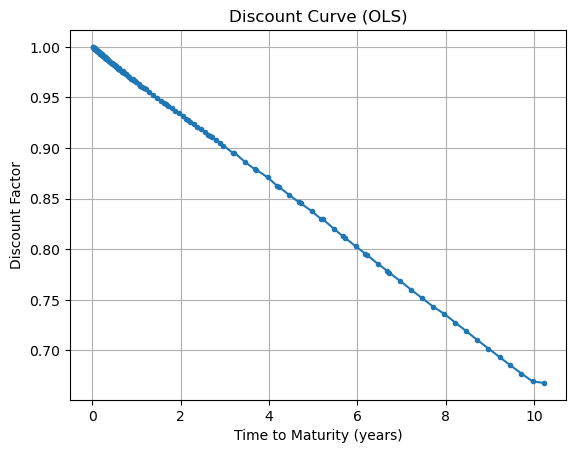

In [426]:
plt.plot(z.index, z, marker="o", markersize=3)
plt.xlabel("Time to Maturity (years)")
plt.ylabel("Discount Factor")
plt.title("Discount Curve (OLS)")
plt.grid(True)
plt.show()

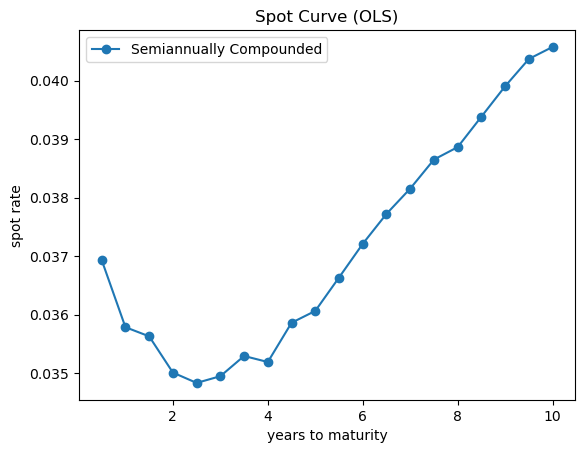

In [427]:
#only include data points every six months
from scipy import interpolate

inc = .5
maturity_grid = np.arange(inc,z.index.to_series().max(),inc)

r_sa = 2 * (z.values ** (-1 / (2 * ttm)) - 1)

f = interpolate.interp1d(ttm, r_sa)
plt.plot(maturity_grid, f(maturity_grid), marker="o", label="Semiannually Compounded")
plt.legend()
plt.title("Spot Curve (OLS)")
plt.xlabel("years to maturity")
plt.ylabel("spot rate")
plt.show()


### 2.3. Nelson-Siegel Curve-Fitting

As in `1.4`, estimate the Nelson-Siegel curve.

In [428]:
x0 = np.array([0, 0, 0, 2])
p_mkt = data.loc[C_hat.index]["dirty price"].to_numpy()

res = minimize(
    loss,
    x0=x0,
    args=(ttm, C_hat, p_mkt),
    method="L-BFGS-B",
    bounds=[(None, None), (None, None), (None, None), (1e-3, None)],
)

theta_hat = res.x

print("theta0: ", theta_hat[0])
print("theta1: ", theta_hat[1])
print("theta2: ", theta_hat[2])
print("lambda: ", theta_hat[3])

theta0:  0.04869353717438685
theta1:  -0.009913502289417802
theta2:  -0.029754189866271933
lambda:  2.285041709242018


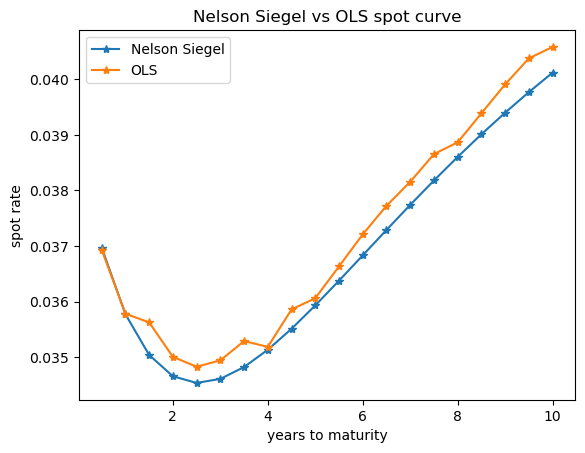

In [429]:
plt.plot(maturity_grid, r_ns(maturity_grid, theta_hat[0], theta_hat[1], theta_hat[2], theta_hat[3]), marker="*", label="Nelson Siegel")
plt.plot(maturity_grid, f(maturity_grid), marker="*", label="OLS")
plt.legend()
plt.title("Nelson Siegel vs OLS spot curve")
plt.xlabel("years to maturity")
plt.ylabel("spot rate")
plt.show()

### 2.4. Weighted Least Squares

Re-do `2.2.`, but this time use Weighted Least Squares. Find a weighting scheme that puts more weight on more recently issued treasures and less weight on less recently issued treasures. 

Does your answer change much?


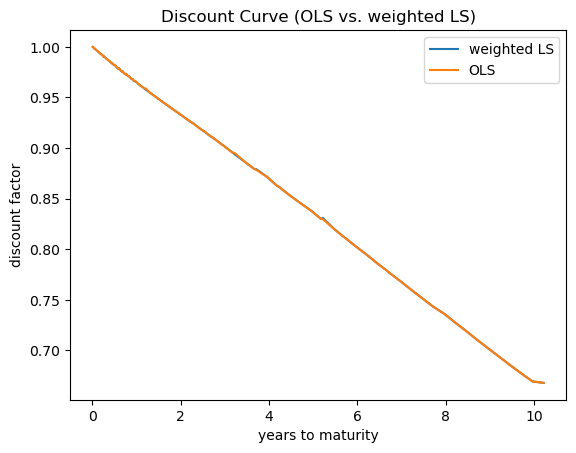

In [432]:
data_filt = data.loc[C_hat.index]
# age in years
age_years = (data_filt["quote date"] - data_filt["issue date"]).dt.days / 365.25

half_life_years = 1  # after 1 year, weight halves
lam = np.log(2) / half_life_years
w = np.exp(-lam * age_years)

model = sm.WLS(p, C_hat, weights=w)
result = model.fit()

plt.plot(ttm, result.params, label="weighted LS")
plt.plot(z.index, z, label="OLS")
plt.title("Discount Curve (OLS vs. weighted LS)")
plt.xlabel("years to maturity")
plt.ylabel("discount factor")
plt.legend()
plt.show()


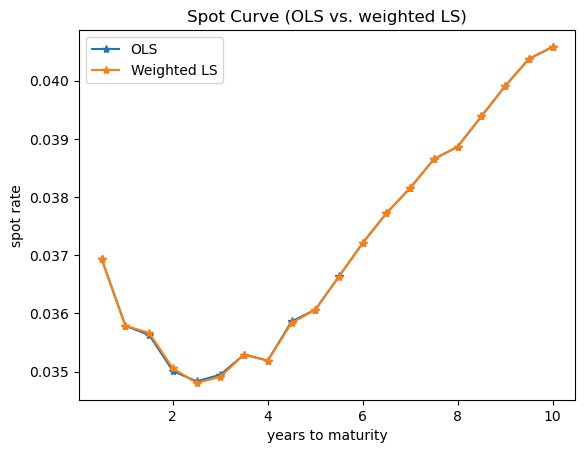

In [433]:
r_sa_wtd = 2 * (result.params.values ** (-1 / (2 * ttm)) - 1)

g = interpolate.interp1d(ttm, r_sa_wtd)
plt.plot(maturity_grid, f(maturity_grid), marker="*", label="OLS")
plt.plot(maturity_grid, g(maturity_grid), marker="*", label="Weighted LS")
plt.legend()
plt.title("Spot Curve (OLS vs. weighted LS)")
plt.xlabel("years to maturity")
plt.ylabel("spot rate")
plt.show()

No, using the exponential decay weighting scheme I chose does not change the answer much at all. The two spot curves are nearly identical, especially for later maturity dates.

***